# RobustBench and AutoAttack

In [1]:
import xlab # for testing your code

from robustbench.utils import load_model
from robustbench.data import load_cifar10
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from autoattack import AutoAttack
import torchattacks
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

We will begin by loading a pretrained model for classification on CIFAR using robustbench.

In [2]:
model = load_model(model_name='Standard', threat_model='Linf')
model = model.to('mps')
_ = model.eval()

First let's take a look at what we have. We can see that there is about 36.5 million trainable pameters in the model. This is actually quite large! For reference, we will be looking at the smallest version of GPT-2 later in the course. That has 128 million parameters, meaning our classifer is only a third of the size of the smallest transformer-based language models.

In [3]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 36,479,194


Next let's look at the architecture. We can see that this is the Wide ResNet we discussed earlier in this course. We encourage you to take a look that the model strucutre to see if you can infer what is going on.

## Task 1: Benchmark WideResNet on Clean Images

Now let's see how robust this base model is. First we will want to benchmark the accuracy of clean images. For compuational efficency, we will only load 100 images from [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). If you would like to load more, and you computer can handle it, we encourage you to do so!

In [4]:
NUM_EXAMPLES = 100
x_test, y_test = load_cifar10(n_examples=NUM_EXAMPLES)
x_test, y_test = x_test.to(device), y_test.to(device)
print(f"{x_test.shape=}, {y_test.shape=}")

x_test.shape=torch.Size([100, 3, 32, 32]), y_test.shape=torch.Size([100])


In [5]:
def benchmark_wideresnet(model, imgs, labels):
    '''return the accuracy of the model as a floating point number between 0.0 and 1.0'''
    acc = 0

    logits = model(imgs)
    pred_labels = torch.argmax(logits, dim=1)
    num_correct = torch.sum(pred_labels == labels)
    total_imgs = len(labels)
    acc = num_correct/total_imgs
    
    return acc.item()

acc = benchmark_wideresnet(model, x_test, y_test)
print(f"Model accuracy is {acc*100:.2f}% for clean images")

Model accuracy is 94.00% for clean images


In [6]:
# This test will make sure you have reasonable accuracy for the first 100 testing images.
# Do NOT change the function below: you do not need to pass in any images or labels.
_ = xlab.tests.section2_4_2.task1(benchmark_wideresnet, model)

Running tests for Section 2.4.2, Task 1...

Using device: mps:0 for testing...
✓ 1. Test case model accuracy > 90%                            PASSED
     Accuracy: 0.9400
✓ 2. Test case student function returns correct accuracy       PASSED
     Expected: 0.9400 (±0.01)
     Got:      0.9400
     Difference: 0.0000

🎉 All tests passed! (2/2)


## Targeted Attack on Model

To show how vunerable this pretrained model is to adversarial attacks, we will benchmark it on a PGD attack with only 20 total steps.

In [7]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
itos = {i: s for i, s in enumerate(classes)}
stoi = {s: i for i, s in itos.items()}

In [8]:
# we are loading a targeted attack with only 20 total steps
pgd = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=20)
pgd.set_mode_targeted_by_label(quiet=True)

As a refresher, the code below will run a targeted attack against the model. In the one example below, we take an image of a horse and run PGD to generate an example that fools the model into thinking it is a frog. After reviewing the example below, move onto task #2.

In [9]:
img_idx = 13 # this is an image of a horse
true_class_idx = y_test[img_idx].item()
target_class = 'frog'

print(f'Running PGD to misclasify {itos[true_class_idx]} as {target_class}...')

adv_images = pgd(x_test[img_idx:img_idx+1], torch.tensor([stoi[target_class]]))

model_adv_pred = torch.argmax(model(adv_images)).item()
model_clean_pred = torch.argmax(model(x_test[img_idx:img_idx+1].to('mps'))).item()

print(f"Clean Predicted Label = '{itos[model_clean_pred]}', Adversarial Predicted Label = '{itos[model_adv_pred]}'")

Running PGD to misclasify horse as frog...
Clean Predicted Label = 'horse', Adversarial Predicted Label = 'frog'


## Task #2: Benchmark on Targeted PGD Attacks

In [10]:
def get_targeted_pgd_imgs(model, img, targets, steps=20, epsilon=8/255):
    '''
    model: WideResNet
    img: torch.tensor of size torch.Size([batch, 3, 32, 32])
    targets: torch.tensor of size torch.Size([batch])
    steps: int
    epsilson: float
    '''
    pgd = torchattacks.PGD(model, eps=epsilon, alpha=2/255, steps=steps)
    pgd.set_mode_targeted_by_label(quiet=True)
    adv_img = pgd(img, targets)

    return adv_img 

In [11]:
_ = xlab.tests.section2_4_2.task2(get_targeted_pgd_imgs, model)

Running tests for Section 2.4.2, Task 2...

Using device: mps:0 for testing...
✓ 1. Test case model accuracy > 90%                            PASSED
     Accuracy: 0.9400
✓ 2. Test case adversarial attack succeeds                     PASSED
     Target class: 9
     Predicted class: 9
     Adversarial attack successfully fooled the model

🎉 All tests passed! (2/2)


We encourage you to play around with the attack you have built to show how brittle a very high accuracy performance classifier can be. Despite having near perfect performance on clean data, you will find that you will be able to fool the model into classifying images from any class to most of the other classes. 

## Demonstrating the Failures of Benchmarks

Now we will propose a defense and benchmark it on two variations of PGD. In other words, we will be doing in what many researchers have been doing for years. As the AutoAttack paper states:

<blockquote>
    <i>Another cause of poor evaluations is the lack of diversity among the attacks used, as most papers rely solely
    on the results given by PGD or weaker versions of it like FGSM.
    </i>
</blockquote>

We will show how doing this can fail in the most extreme way by demonstrating a defense that works quite well against PGD but fails entirely on a black box attack. Admittedly, the defense that we cover is perhaps too silly for a competent researcher to take seriously, but we beleive that by working through this example, you will develop good intuitions about how benchmarking attack sucess can be misleading.

To be very clear: <b>We do not present the below defense because it is good.</b> We present it because it will <i>appear</i> good
under a poorly designed evaluation.

If you print the model, you will see that the model is using a [ReLU activation function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)). ReLU non-linearities give very clean gradients:

$$
\frac{d}{dx}\text{ReLU}(x) = \frac{d}{dx}\max(0, x) = \begin{cases} 
1 & \text{if } x > 0 \\
0 & \text{if } x < 0 \\
\text{undefined} & \text{if } x = 0
\end{cases}
$$

In PyTorch, when x=0, the gradient of x is 0 rather than being undefined. We can demonstrate the above equation with the code below.

In [12]:
x_1 = torch.tensor(0.0, requires_grad=True)
x_2 = torch.tensor(-1.0, requires_grad=True)
x_3 = torch.tensor(1.0, requires_grad=True)

for x in [x_1, x_2, x_3]:     
    out = F.relu(x)
    out.backward()

print(x_1.grad, x_2.grad, x_3.grad)

tensor(0.) tensor(0.) tensor(1.)


We will now build out a defense where we manipulate the gradients of the ReLU activation function without doing much to affect the forward pass. Consider the following variation of ReLU which we will call wiggly ReLU:

$$
\text{WiggleReLU}(x) = \text{ReLU}(x) + \alpha \sin(\omega x) = \max(0, x) + \alpha \sin(\omega x)
$$

This gives the following gradients:

$$
\frac{d}{dx}\text{WiggleReLU}(x) = \begin{cases} 
1 + \alpha \omega \cos(\omega x) & \text{if } x > 0 \\
\alpha \omega \cos(\omega x) & \text{if } x \leq 0
\end{cases}
$$

Depending on the magnitude of the amplitude parameter ($\alpha$) and the frequency parameter ($\omega$), you will get increasing different gradients compared to the vanilla ReLU function. In task #3 and #4 you will implement WiggleReLU, and examine the gradients it produces. In task #5, you will show that by substituting all ReLUs with WiggleReLU in our original model, attacks like PGD, CW, or FGSM will no longer work. 

## Task #3 WiggleReLU

In [13]:
def wiggle_ReLU(x, amplitude=0.1, frequency=150):
    '''implement WiggleReLU to every item in the x tensor. 
    
    NOTE: "amplitude" and "frequency" are represented as alpha and omega above.
    '''
    return F.relu(x) + amplitude * torch.sin(x * frequency)

In [14]:
_ = xlab.tests.section2_4_2.task3(wiggle_ReLU)

Running tests for Section 2.4.2, Task 3...

✓ 1. Test case 1D tensor, default params                       PASSED
     Input shape: [5]
     Amplitude: 0.1, Frequency: 150
✓ 2. Test case 2D tensor, default params                       PASSED
     Input shape: [2, 2]
     Amplitude: 0.1, Frequency: 150
✓ 3. Test case 3D tensor, default params                       PASSED
     Input shape: [2, 2, 2]
     Amplitude: 0.1, Frequency: 150
✓ 4. Test case 1D tensor, amplitude=0.05                       PASSED
     Input shape: [4]
     Amplitude: 0.05, Frequency: 150
✓ 5. Test case 1D tensor, amplitude=0.2                        PASSED
     Input shape: [4]
     Amplitude: 0.2, Frequency: 150
✓ 6. Test case 1D tensor, frequency=100                        PASSED
     Input shape: [4]
     Amplitude: 0.1, Frequency: 100
✓ 7. Test case 1D tensor, frequency=200                        PASSED
     Input shape: [4]
     Amplitude: 0.1, Frequency: 200
✓ 8. Test case all zeros                          

## Task #4 WiggleReLU gradient

In our solution solution to task #4, we clone x and calucate the gradient using PyTorch's autograd. We also encourage you to try to implement the solution without autograd (to do this you would find the derivative of WiggleReLU by hand).

<details>
<summary>💡 <b>Hint for wiggle_Relu_grad</b></summary>

If you are computing wiggle_Relu_grad, you cannot call out.backward() if out is a non-scalar tensor. You can do torch.sum(out).backward() to effectively call backward on each out the ouputs. The reason this works is the partial derivative of each input to a sum function is always 1. 

</details>

In [15]:
def wiggle_ReLU_grad(x, amplitude=0.1, frequency=150):
    '''find the gradient of the wiggle_ReLU function above'''
    grad = torch.zeros_like(x) # you can overwrite this if you would like

    x_cloned = x.clone().requires_grad_(True)
    out = wiggle_ReLU(x_cloned, amplitude, frequency)
    torch.sum(out).backward()
    
    return x_cloned.grad

In [16]:
_ = xlab.tests.section2_4_2.task4(wiggle_ReLU_grad)

Running tests for Section 2.4.2, Task 4...

✓ 1. Test case 1D tensor, default params                       PASSED
     Input shape: [5]
     Amplitude: 0.1, Frequency: 150
✓ 2. Test case 2D tensor, default params                       PASSED
     Input shape: [2, 2]
     Amplitude: 0.1, Frequency: 150
✓ 3. Test case 3D tensor, default params                       PASSED
     Input shape: [2, 2, 2]
     Amplitude: 0.1, Frequency: 150
✓ 4. Test case 1D tensor, amplitude=0.05                       PASSED
     Input shape: [4]
     Amplitude: 0.05, Frequency: 150
✓ 5. Test case 1D tensor, amplitude=0.2                        PASSED
     Input shape: [4]
     Amplitude: 0.2, Frequency: 150
✓ 6. Test case 1D tensor, frequency=100                        PASSED
     Input shape: [4]
     Amplitude: 0.1, Frequency: 100
✓ 7. Test case 1D tensor, frequency=200                        PASSED
     Input shape: [4]
     Amplitude: 0.1, Frequency: 200
✓ 8. Test case all zeros                          

Now let's take a look how wiggle_ReLU scrambles gradients: 

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import math

def custom_imshow(tensors, ncols=3, colorbar=True, log_scale=False, titles=None, figsize=None, **kwargs):
    """
    Custom imshow for multiple tensors: negative=navy, zero=white, positive=maroon
    
    Parameters:
    -----------
    tensors : list of array-like
        List of 2D tensors to display
    ncols : int, default=3
        Number of columns in the grid
    colorbar : bool, default=True
        Whether to show colorbars
    log_scale : bool, default=False
        Whether to use symmetric log scale for colorbar
    titles : list of str, optional
        Custom titles for each tensor. If None, uses "Tensor 1", "Tensor 2", etc.
    figsize : tuple, optional
        Figure size (width, height)
    **kwargs : dict
        Additional arguments passed to imshow
    """
    
    # Convert to list if single tensor passed
    if not isinstance(tensors, (list, tuple)):
        tensors = [tensors]
    
    # Convert all to numpy arrays
    tensors = [np.asarray(t) for t in tensors]
    
    # Assert all tensors have the same shape
    shapes = [t.shape for t in tensors]
    assert all(shape == shapes[0] for shape in shapes), \
        f"All tensors must have the same shape. Got shapes: {shapes}"
    
    # Assert titles length matches number of tensors if provided
    if titles is not None:
        assert len(titles) == len(tensors), \
            f"Number of titles ({len(titles)}) must match number of tensors ({len(tensors)})"
    
    # Calculate grid dimensions
    ntensors = len(tensors)
    nrows = math.ceil(ntensors / ncols)
    
    # Calculate global vmin/vmax for consistent scaling
    all_values = np.concatenate([t.flatten() for t in tensors])
    vmax = np.max(np.abs(all_values))
    
    # Create colormap
    cmap = mcolors.LinearSegmentedColormap.from_list('custom', ['navy', 'white', 'maroon'])
    
    # Set up plot defaults
    defaults = {'cmap': cmap}
    
    # Add normalization
    if log_scale:
        # Use symmetric log norm to handle negative, zero, and positive values
        # linthresh determines the linear threshold around zero
        linthresh = vmax / 100  # Linear region is 1% of max value
        defaults['norm'] = mcolors.SymLogNorm(linthresh=linthresh, vmin=-vmax, vmax=vmax)
    else:
        # Use regular linear normalization
        defaults.update({'vmin': -vmax, 'vmax': vmax})
    
    defaults.update(kwargs)
    
    # Create figure and subplots
    if figsize is None:
        figsize = (4 * ncols, 4 * nrows)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    # Handle case where we have only one subplot
    if ntensors == 1:
        axes = [axes]
    elif nrows == 1:
        axes = axes.reshape(1, -1)
    elif ncols == 1:
        axes = axes.reshape(-1, 1)
    
    # Flatten axes for easy iteration
    axes_flat = axes.flatten() if hasattr(axes, 'flatten') else axes
    
    # Plot each tensor
    images = []
    for i, tensor in enumerate(tensors):
        ax = axes_flat[i]
        im = ax.imshow(tensor, **defaults)
        
        # Use custom title if provided, otherwise default
        title = titles[i] if titles is not None else f'Tensor {i+1}'
        ax.set_title(title)
        
        images.append(im)
        
        if colorbar:
            plt.colorbar(im, ax=ax, shrink=0.6, aspect=20)
    
    # Hide unused subplots
    for i in range(ntensors, len(axes_flat)):
        axes_flat[i].set_visible(False)
    
    plt.tight_layout()
    return fig, images

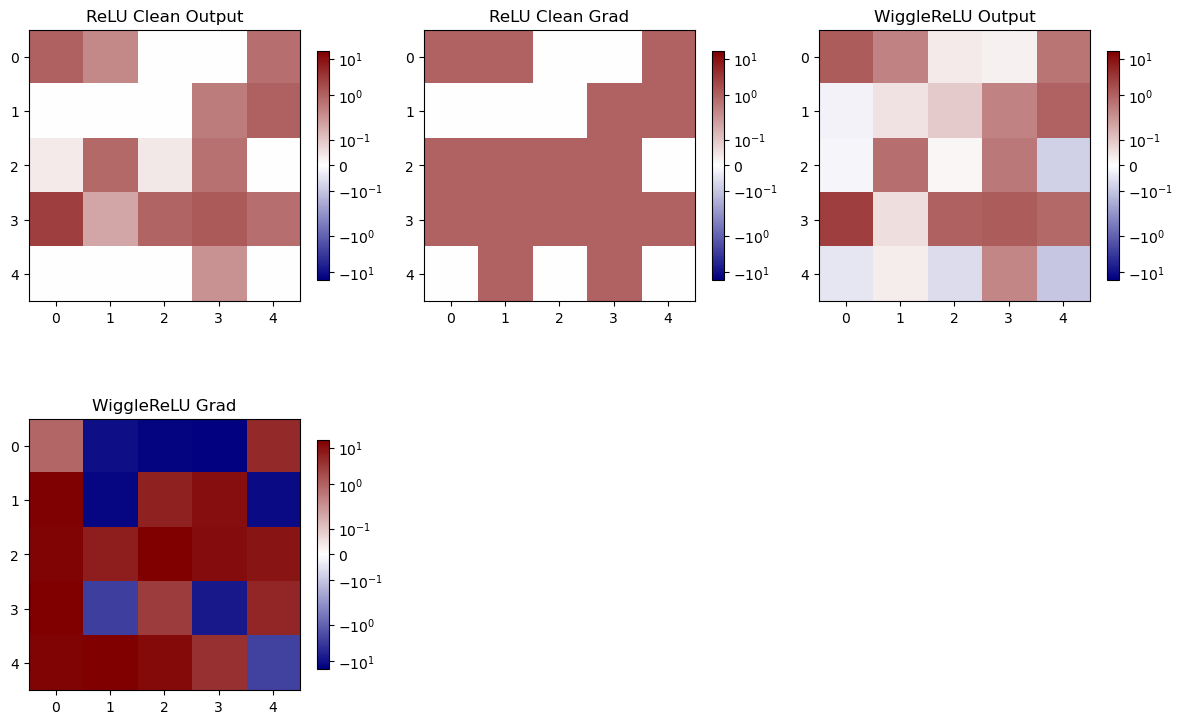

In [20]:
input_tensor = torch.randn((5,5))
relu_out = F.relu(input_tensor)
relu_grad = torch.ones_like(input_tensor)
relu_grad[input_tensor <=0] = 0

wiggle_relu_out = wiggle_ReLU(input_tensor)
wiggle_relu_grad = wiggle_ReLU_grad(input_tensor)

_ = xlab.utils.plot_tensors(
    [relu_out, relu_grad, wiggle_relu_out,wiggle_relu_grad], 
    log_scale=True,
    titles = ["ReLU Clean Output", "ReLU Clean Grad", "WiggleReLU Output", "WiggleReLU Grad"]
)

## Task #5 Replacing ReLU with WiggleReLU

To replace the ReLU functions within the model, we need to make wiggle_ReLU a class that inherits the `nn.Module` class. We have taken care of creating this class for you below.

In [ ]:
class WiggleReLU(nn.Module):
    def __init__(self, amplitude=0.1, frequency=150):
        super(WiggleReLU, self).__init__()
        self.frequency = frequency
        self.amplitude = amplitude
    
    def forward(self, x):
        return wiggle_ReLU(x, amplitude=self.amplitude, frequency=self.frequency) # this is the function you implemented for task 3

Now you will replace all of the ReLU activations with the WiggleReLU class. Once you have modified your modified model, you will pass it to `xlab.tests.section2_4_2.task4` which will confirm that your implementation is correct. 

<details>
<summary>💡 <b>Hint 1 for Task #5</b></summary>

You can extract a ReLU activation from the model using the following code.
`model.block1.layer[0].relu1`

</details>

<details>
<summary>💡 <b>Hint 2 for Task #5</b></summary>

You can extract replace a ReLU activation from the model using the following code.
`model.block1.layer[0].relu1 = WiggleReLU()`

</details>

In [ ]:
########### YOUR CODE HERE ###########

# zephy's solution
wiggle_relu = WiggleReLU(frequency=100000)
for layer in range(4):

    # update block 1
    model.block1.layer[layer].relu1 = wiggle_relu
    model.block1.layer[layer].relu2 = wiggle_relu

    # update block 2
    model.block2.layer[layer].relu1 = wiggle_relu
    model.block2.layer[layer].relu2 = wiggle_relu

    # update block 3
    model.block3.layer[layer].relu1 = wiggle_relu
    model.block3.layer[layer].relu2 = wiggle_relu

model.relu = wiggle_relu

## Benchmarking Our 'Defense' Using AutoAttack

Now you are ready to benchmark your defense using auto attack. Let's use a cheaper version of AutoAttack to get an early idea of how effective our defense is. The code in the following block is taken directly from [this notebook](https://colab.research.google.com/drive/1MQY_7O9vj7ixD5ilVRbdQwlNPFvxifHV#scrollTo=YLGmSORskSW0) released along with the [RobustBench GitHub repo](https://github.com/RobustBench/robustbench?tab=readme-ov-file).

<b>NOTE: </b>Even the cheaper attack may take quite a long time to run. If you run into this issue you can modify `NUM_EXAMPES` to a smaller value. You can also just reference the expected output dropdown below if you don't want to run the evaluation locally.

<details>
<summary>💻 <b>Expected output for the cell below</b></summary>

```
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 93.00%
apgd-ce - 1/1 - 9 out of 93 successfully perturbed
robust accuracy after APGD-CE: 84.00% (total time 341.5 s)
Warning: there are 1 points with zero gradient! This might lead to unreliable evaluation with gradient-based attacks. See flags_doc.md for details.
apgd-dlr - 1/1 - 6 out of 84 successfully perturbed
robust accuracy after APGD-DLR: 78.00% (total time 542.2 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 78.00%
```

</details>


In [15]:
NUM_EXAMPES = 100 # make this lower if the cell takes too long to run

adversary = AutoAttack(model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device ='mps')
adversary.apgd.n_restarts = 1
x_adv = adversary.run_standard_evaluation(x_test[:NUM_EXAMPES], y_test[:NUM_EXAMPES])

using custom version including apgd-ce, apgd-dlr.
initial accuracy: 93.00%
apgd-ce - 1/1 - 12 out of 93 successfully perturbed
robust accuracy after APGD-CE: 81.00% (total time 146.5 s)
apgd-dlr - 1/1 - 2 out of 81 successfully perturbed
robust accuracy after APGD-DLR: 79.00% (total time 278.0 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 79.00%


### Why you cannot trust the above result

You should see a number ~78%. Note that if this result was representitive our defense's robustness, our model would have state of the art adversarial robustness by a healthy margin. You can examine leaderboard for RobustBench below to see that state of the art accuracy is hovering ~74%.

<div align="center">
  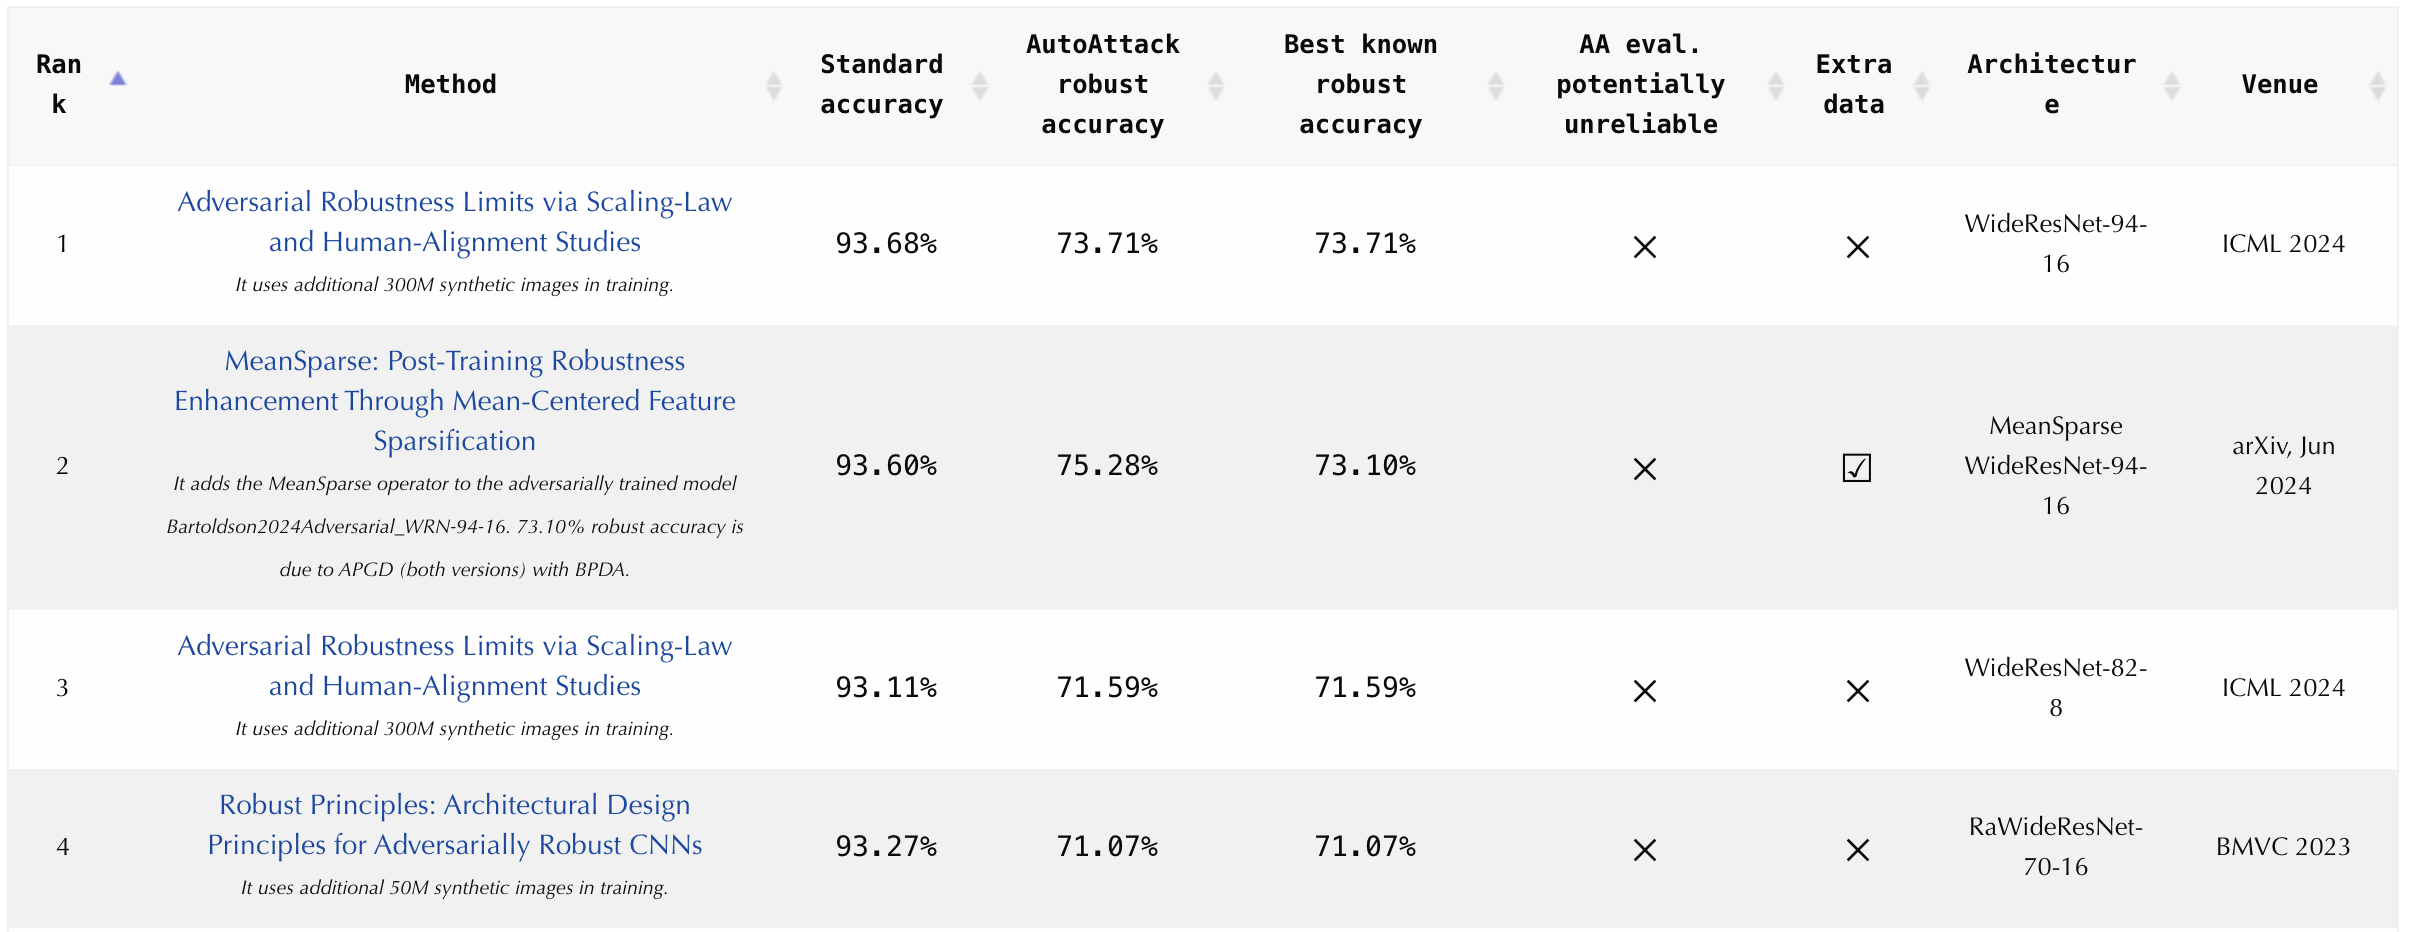
</div>

So did we make a breakthough? Is it time to publish our findings? Unfortunately no. Let's try a complete version of AutoAttack to see where things went wrong.

## Using AutoAttack to compute a more comprehensive evaluation.

<details>
<summary>💻 <b>Expected output for the cell below</b></summary>

```
setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 90.00%
apgd-ce - 1/1 - 0 out of 9 successfully perturbed
robust accuracy after APGD-CE: 90.00% (total time 17.1 s)
apgd-t - 1/1 - 2 out of 9 successfully perturbed
robust accuracy after APGD-T: 70.00% (total time 166.5 s)
fab-t - 1/1 - 0 out of 7 successfully perturbed
robust accuracy after FAB-T: 70.00% (total time 442.8 s)
square - 1/1 - 7 out of 7 successfully perturbed
robust accuracy after SQUARE: 0.00% (total time 458.7 s)
Warning: Square Attack has decreased the robust accuracy of 70.00%. This might indicate that the robustness evaluation using AutoAttack is unreliable. Consider running Square Attack with more iterations and restarts or an adaptive attack. See flags_doc.md for details.
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%
```

</details>

In [17]:
NUM_EXAMPES = 10 # adjust this number based on your hardware

# this will run AutoAttack with apgd-ce, apgd-t, fab-t, square
adversary = AutoAttack(model, norm='Linf', eps=8/255, device='mps') 
adversary.apgd.n_restarts = 1
x_adv = adversary.run_standard_evaluation(x_test[:NUM_EXAMPES], y_test[:NUM_EXAMPES])

setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 90.00%
apgd-ce - 1/1 - 0 out of 9 successfully perturbed
robust accuracy after APGD-CE: 90.00% (total time 17.1 s)
apgd-t - 1/1 - 2 out of 9 successfully perturbed
robust accuracy after APGD-T: 70.00% (total time 166.5 s)
fab-t - 1/1 - 0 out of 7 successfully perturbed
robust accuracy after FAB-T: 70.00% (total time 442.8 s)
square - 1/1 - 7 out of 7 successfully perturbed
robust accuracy after SQUARE: 0.00% (total time 458.7 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%


In [63]:
a = torch.randn((3,3))
wiggle_ReLU(a)

tensor([[-0.0994, -0.0907,  0.0984],
        [ 0.0996,  0.0453,  0.0943],
        [ 0.0824,  0.3920,  0.0475]])

In [64]:
wiggle_Relu_grad(a)

tensor([[-1.6658,  6.3243, -2.6826],
        [ 1.3347, 13.3700, -5.0002],
        [-8.4946, -0.3377, 13.1977]])

In [5]:
print(model)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNor

Before continuing we encourage you to brainstorm:

1. Why this defense would be effective against an attack like PGD or CW
2. Why benchmarking ONLY against PGD, CW, or FGSM would give deceptive results

After thinking for a while, run the benchmarks below:

In [72]:
model

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): WiggleReLU()
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): WiggleReLU()
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): WiggleReLU()
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05

In [8]:
model = model.to('mps')

In [10]:
from autoattack import AutoAttack

adversary = AutoAttack(model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device ='mps')
adversary.apgd.n_restarts = 1
x_adv = adversary.run_standard_evaluation(x_test[:5], y_test[:5])

using custom version including apgd-ce, apgd-dlr.
initial accuracy: 100.00%
apgd-ce - 1/1 - 5 out of 5 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 9.5 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%


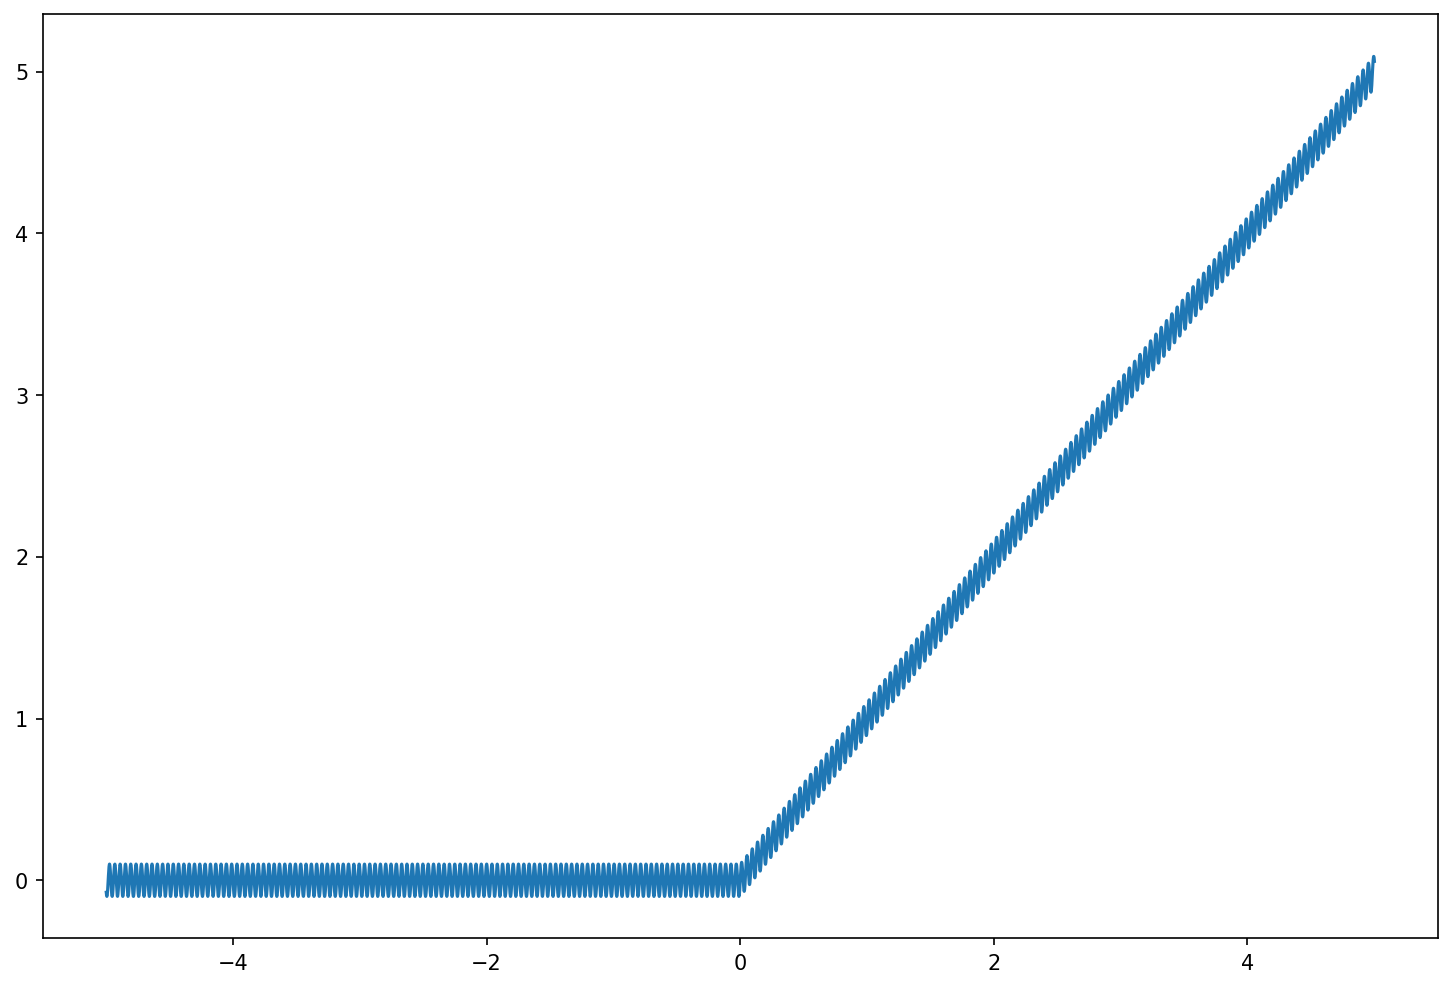

In [54]:
import torch
from torch import nn
import matplotlib.pyplot as plt

def wiggle_relu(x):
    return nn.functional.relu(x) + 0.1*torch.sin(150 * x)

x = torch.arange(-5, 5.001, 0.001)
y = wiggle_relu(x)

plt.figure(figsize=(12, 8), dpi=150)  # High resolution with larger size
plt.plot(x.numpy(), y.numpy())
plt.show()

In [64]:
model

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNor

In [67]:
class WiggleReLU(nn.Module):
    def __init__(self):
        super(WiggleReLU, self).__init__()
    
    def forward(self, x):
        return nn.functional.relu(x) + 0.1*torch.sin(100000 * x)

model.block1.layer[0].relu2 = WiggleReLU()
model.block1.layer[0].relu1 = WiggleReLU()
model.block1.layer[1].relu2 = WiggleReLU()
model.block1.layer[1].relu1 = WiggleReLU()
model.block1.layer[2].relu2 = WiggleReLU()
model.block1.layer[2].relu1 = WiggleReLU()
model.block1.layer[3].relu2 = WiggleReLU()
model.block1.layer[3].relu1 = WiggleReLU()

model.block2.layer[0].relu2 = WiggleReLU()
model.block2.layer[0].relu1 = WiggleReLU()
model.block2.layer[1].relu2 = WiggleReLU()
model.block2.layer[1].relu1 = WiggleReLU()
model.block2.layer[2].relu2 = WiggleReLU()
model.block2.layer[2].relu1 = WiggleReLU()
model.block2.layer[3].relu2 = WiggleReLU()
model.block2.layer[3].relu1 = WiggleReLU()

model.block3.layer[0].relu2 = WiggleReLU()
model.block3.layer[0].relu1 = WiggleReLU()
model.block3.layer[1].relu2 = WiggleReLU()
model.block3.layer[1].relu1 = WiggleReLU()
model.block3.layer[2].relu2 = WiggleReLU()
model.block3.layer[2].relu1 = WiggleReLU()
model.block3.layer[3].relu2 = WiggleReLU()
model.block3.layer[3].relu1 = WiggleReLU()

In [70]:
from autoattack import AutoAttack

adversary = AutoAttack(model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device ='mps')
adversary.apgd.n_restarts = 1
x_adv = adversary.run_standard_evaluation(x_test[:100], y_test[:100])

using custom version including apgd-ce, apgd-dlr.
initial accuracy: 96.00%
apgd-ce - 1/1 - 5 out of 48 successfully perturbed
robust accuracy after APGD-CE: 86.00% (total time 79.4 s)
apgd-dlr - 1/1 - 1 out of 43 successfully perturbed
robust accuracy after APGD-DLR: 84.00% (total time 153.0 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 84.00%


In [71]:
from autoattack import AutoAttack

adversary = AutoAttack(model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr', 'square'], device ='mps')
adversary.apgd.n_restarts = 1
x_adv = adversary.run_standard_evaluation(x_test[:100], y_test[:100])

using custom version including apgd-ce, apgd-dlr, square.
initial accuracy: 96.00%
apgd-ce - 1/1 - 3 out of 48 successfully perturbed
robust accuracy after APGD-CE: 90.00% (total time 77.5 s)
apgd-dlr - 1/1 - 3 out of 45 successfully perturbed
robust accuracy after APGD-DLR: 84.00% (total time 152.0 s)
square - 1/1 - 32 out of 42 successfully perturbed
robust accuracy after SQUARE: 20.00% (total time 713.9 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 20.00%


In [5]:
from robustbench.data import load_cifar10
x_test, y_test = load_cifar10(n_examples=50) # load CIFAR 10

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:07<00:00, 22.3MB/s]
